# Text Similarity

##### Author: Alex Sherman | alsherman@deloitte.com

### Agenda:

- Levenshtein distance
- Jaccard distance
- Euclidean distance
- Cosine similarity
- Similarity with [sklearn, gensim, spacy]
- Word2vec similarity
- Word movers distance

"we often want to determine **similarity between pairs of documents**, or the **similarity between a specific document** and a set of other documents (such as a user query vs. indexed documents).


### Use cases:
Broad:
- information retrieval
- document clustering
- word-sense disambiguation
- automatic essay scoring
- short answer grading
- machine translation
- Recommendation Engines
- Search Engines (Query - Result matching)

Specific:
- Grant similarity
- Complaint similarity
- Duplicate questions
- Question Answering (e.g. give the same style of question to a customer support agent)

In [33]:
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.display import display, HTML
from IPython.display import Image
from IPython.lib.display import YouTubeVideo
from configparser import ConfigParser, ExtendedInterpolation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
import spacy
from spacy.matcher import Matcher
from gensim import corpora, models, similarities

# increase display of columns in pandas
pd.set_option('display.max_colwidth',200)

import warnings
warnings.filterwarnings('ignore')

In [34]:
# configuration for data, acronyms, and gensim paths
config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../../config.ini')

GENSIM_DICTIONARY_PATH = config['NLP']['GENSIM_DICTIONARY_PATH']
GENSIM_CORPUS_PATH = config['NLP']['GENSIM_CORPUS_PATH']
AIRLINE_CLEANED_TEXT_PATH = config['NLP']['AIRLINE_CLEANED_TEXT_PATH']
SIMILARITY_INDEX = config['NLP']['SIMILARITY_INDEX']

### Review Cleaned Text

In [35]:
with open(AIRLINE_CLEANED_TEXT_PATH, 'rb') as f:
    cleaned_text = [line.decode('utf-8').strip() for line in f.readlines()]
    cleaned_text = list(set(cleaned_text))  # remove duplicates

cleaned_text_df = pd.DataFrame(cleaned_text, columns=['text'])
cleaned_text_df.head()

,text
0,the plaintiff in the consolidate florida action have file a motion seek a award of fee in the amount of which the defendant have oppose
1,in congress_may_consider comprehensive_tax reform_legislation which can result_in_a_low corporate_tax rate_and_the_elimination of certain_tax deduction_and_preference a good a separate legislation...
2,landing_fee and other rental_per_available_seat_mile increase_percent primarily_a_a_result of the company expansion of facility at several airport include baltimore washington international airpor...
3,vided that with respect to revocation the certificate ginning february a per enplanement holder have 1 be advise of the allege violation and security fee be impose on passenger maximum of fail to ...
4,as discuss below under ancillary services and fees during southwest intend to implement a service charge for reuse of fund associate with wanna get away ticket that be not cancel or change prior t...


### Text Similarity Approaches

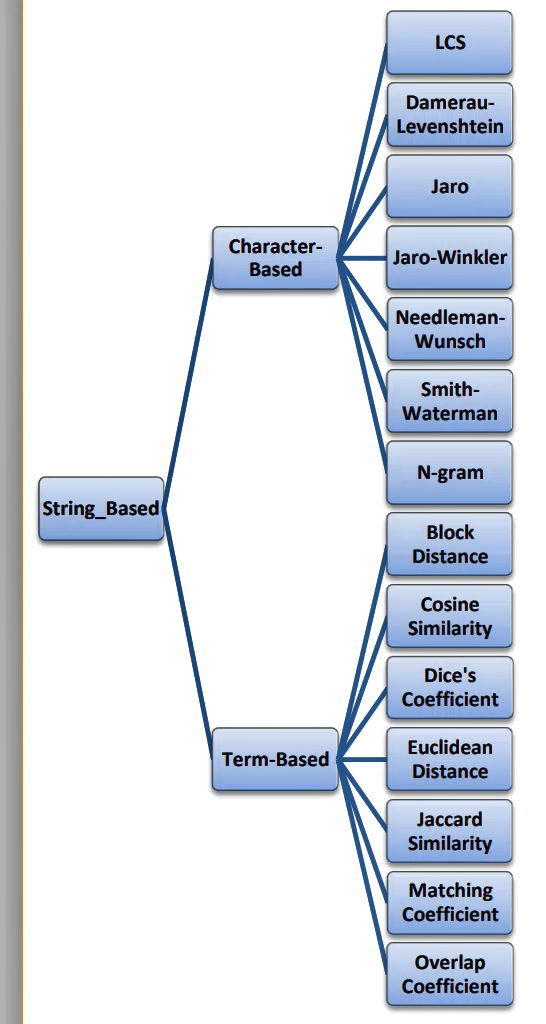

In [36]:
# text similarity approaches
# https://pdfs.semanticscholar.org/5b5c/a878c534aee3882a038ef9e82f46e102131b.pdf
Image("../../raw_data/images/text_similarity_approaches.png", width=350)

## Character Based Text Similarity

"As an example, this technology is used by information retrieval systems, search engines, automatic indexing systems, text summarizers, categorization systems, plagiarism checkers, speech recognition, rating systems, DNA analysis, and profiling algorithms (IR/AI programs to automatically link data between people and what they do)."

##### The Levenshtein Distance

"This method was invented in 1965 by the Russian Mathematician Vladimir Levenshtein (1935-2017). The distance value describes the minimal number of deletions, insertions, or substitutions that are required to transform one string (the source) into another (the target). Unlike the Hamming distance, the Levenshtein distance works on strings with an unequal length."

SOURCE: [Levenshtein Distance and Text Similarity in Python](http://stackabuse.com/levenshtein-distance-and-text-similarity-in-python/)

In [37]:
seq1 = 'airline'
seq2 = 'airplane'

# create a matrix
size_x = len(seq1) + 1
size_y = len(seq2) + 1
matrix = np.zeros ((size_x, size_y))
matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [38]:
# set col numbers (0, n-1)
for x in range(size_x):
    matrix [x, 0] = x

# set row numbers (0, n-1)
for y in range(size_y):
    matrix [0, y] = y

matrix

array([[0., 1., 2., 3., 4., 5., 6., 7., 8.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 0., 0., 0., 0., 0., 0., 0., 0.],
       [3., 0., 0., 0., 0., 0., 0., 0., 0.],
       [4., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 0., 0., 0., 0., 0., 0., 0., 0.],
       [6., 0., 0., 0., 0., 0., 0., 0., 0.],
       [7., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [39]:
import numpy as np

def levenshtein(seq1, seq2):
    # create a matrix
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    
    # set col numbers (0, n-1)
    for x in range(size_x):
        matrix [x, 0] = x
    
    # set row numbers (0, n-1)
    for y in range(size_y):
        matrix [0, y] = y

    # calculate distance
    for x in range(1, size_x):
        for y in range(1, size_y):
            # if characters match do not increase distance
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = matrix[x-1, y-1]
            # if characters don't match increase min distance by 1
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )

    # print the distance calulation matrix
    # list(seq1) converts string into a list of the characters
    print(pd.DataFrame(matrix[1:,1:], index=list(seq1), columns=list(seq2)))
    
    return (matrix[size_x - 1, size_y - 1])

levenshtein('airline','airplane')

     a    i    r    p    l    a    n    e
a  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0
i  1.0  0.0  1.0  2.0  3.0  4.0  5.0  6.0
r  2.0  1.0  0.0  1.0  2.0  3.0  4.0  5.0
l  3.0  2.0  1.0  1.0  1.0  2.0  3.0  4.0
i  4.0  3.0  2.0  2.0  2.0  2.0  3.0  4.0
n  5.0  4.0  3.0  3.0  3.0  3.0  2.0  3.0
e  6.0  5.0  4.0  4.0  4.0  4.0  3.0  2.0


2.0

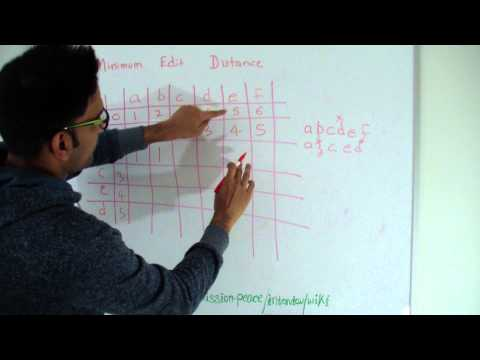

In [40]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('We3YDTzNXEk')

## Term Based Text Similarity

In [41]:
# create a document-term matrix for the first 10 documents
vect = CountVectorizer(max_features=10)
transform_vect = vect.fit_transform(cleaned_text_df['text'][0:10])

# rename the indices as doc_#
index = ['doc_{}'.format(i) for i in range(10)]

# create a dataframe and view two similar documents
dist_df = pd.DataFrame(
      transform_vect.todense()
    , columns=vect.get_feature_names()
    , index=index
)
dist_df.iloc[[1,7],:]

,and,be,fee,for,in,of,one,per,the,to
doc_1,1,0,1,0,1,2,1,0,2,0
doc_7,0,0,1,2,1,0,0,0,1,0


### Jaccard Index

"The Jaccard Index is a statistic to compare and measure how similar two different sets to each other. It is a ratio of intersection of two sets over union of them.

If you have representative finite number of elements for a particular observation and you want to compare this observation with another observation, you could count the number of items that are common to both of these two sets. It is a natural fit for comparing posts if you know the representative tags for the posts to measure how similar two articles are in terms of tags."

SOURCE: http://bugra.github.io/work/notes/2017-02-07/similarity-via-jaccard-index/

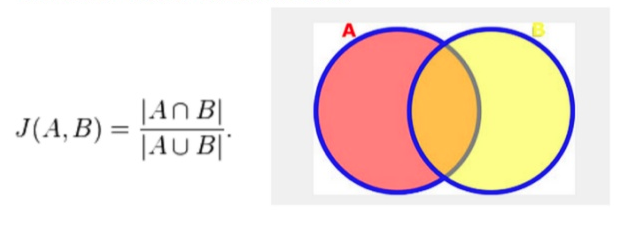

In [42]:
# Similarity via the Jaccard Index
Image("../../raw_data/images/jaccard_index.png", width=450)

In [43]:
# calculate the distance among different vectors
#
# NOTE: if both counts are zero, then the term in not counted in the denominator
#       as the term is outside of the union of both term sets

from sklearn.metrics.pairwise import pairwise_distances

# calculate jaccard distance on all documents
jaccard = pairwise_distances(dist_df, metric='jaccard')

for doc_ind in range(0,8):
    print(dist_df.iloc[[0,doc_ind],:])  # print the first doc and the comparison document
    print('jaccard distance {}'.format(jaccard[0][doc_ind])) # focus on the first doc (index 0)
    print()

       and  be  fee  for  in  of  one  per  the  to
doc_0    0   0    1    0   2   2    0    0    4   0
doc_0    0   0    1    0   2   2    0    0    4   0
jaccard distance 0.0

       and  be  fee  for  in  of  one  per  the  to
doc_0    0   0    1    0   2   2    0    0    4   0
doc_1    1   0    1    0   1   2    1    0    2   0
jaccard distance 0.3333333333333333

       and  be  fee  for  in  of  one  per  the  to
doc_0    0   0    1    0   2   2    0    0    4   0
doc_2    2   0    0    0   0   2    0    0    1   0
jaccard distance 0.6

       and  be  fee  for  in  of  one  per  the  to
doc_0    0   0    1    0   2   2    0    0    4   0
doc_3    1   3    1    0   0   2    1    2    2   3
jaccard distance 0.6666666666666666

       and  be  fee  for  in  of  one  per  the  to
doc_0    0   0    1    0   2   2    0    0    4   0
doc_4    1   1    0    1   0   1    0    0    0   2
jaccard distance 0.875

       and  be  fee  for  in  of  one  per  the  to
doc_0    0   0    1    0  

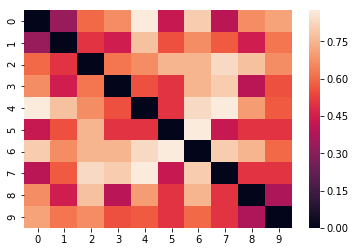

In [44]:
sns.heatmap(pairwise_distances(dist_df, Y=None, metric='jaccard'));

In [45]:
print('SIMILAR:')
print(cleaned_text_df['text'][[8,3]].values)
print('\nDISSIMILAR:')
print(cleaned_text_df['text'][[8,9]].values)

SIMILAR:
['during 1_quarter southwest begin sell open premium board_position systemwide at the gate for a charge per flight increase the amount customers pay for its earlybird_check in product from per one way ticket to per one way ticket and increase the fee charge for certain check excess baggage'
 'vided that with respect to revocation the certificate ginning february a per enplanement holder have 1 be advise of the allege violation and security fee be impose on passenger maximum of fail to comply after be give a reasonable time to do per one way_trip']

DISSIMILAR:
['during 1_quarter southwest begin sell open premium board_position systemwide at the gate for a charge per flight increase the amount customers pay for its earlybird_check in product from per one way ticket to per one way ticket and increase the fee charge for certain check excess baggage'
 'first the propose_rule would require_airline to share_with_ticket agent fee information_for_basic ancillary_service include fee fo

### Euclidean Distance

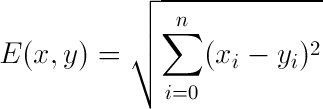

In [46]:
# Euclidean Distance
Image("../../raw_data/images/euclid_eqn.gif", width=300)

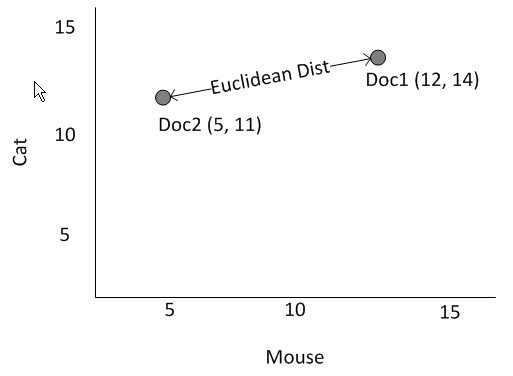

In [47]:
# the geometric equation of the dot product
Image("../../raw_data/images/euclidean_distance.jpg", width=300)

In [48]:
def euclidean_distance(x, y):   
    return np.sqrt(np.sum((x - y) ** 2))

In [49]:
# example from above diagram
p1 = np.array([5,11])
p2 = np.array([12,14])
euclidean_distance(x=p1,y=p2)

7.615773105863909

In [50]:
# the distance between a vect and itself is 0
euclid_df = dist_df 
euclidean_distance(euclid_df.iloc[0],euclid_df.iloc[0])

0.0

In [51]:
# calculate the distance among different vectors
for doc_ind in range(1,5):
    print(euclidean_distance(euclid_df.iloc[0],euclid_df.iloc[doc_ind]))

2.6457513110645907
4.242640687119285
5.656854249492381
5.385164807134504


[0.         2.64575131 4.24264069 5.65685425 5.38516481 3.60555128
 5.29150262 4.24264069 5.47722558 4.58257569]


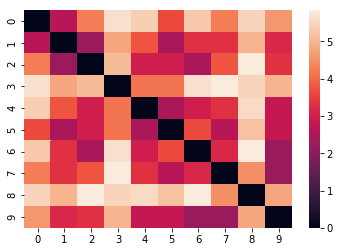

In [52]:
print(pairwise_distances(euclid_df, Y=None, metric='euclidean')[0])
sns.heatmap(pairwise_distances(euclid_df, Y=None, metric='euclidean'));

In [53]:
print('SIMILAR:')
print(cleaned_text_df['text'][[1,6]].values)

print('\nDISSIMILAR:')
print(cleaned_text_df['text'][[3,7]].values)

SIMILAR:
['in congress_may_consider comprehensive_tax reform_legislation which can result_in_a_low corporate_tax rate_and_the_elimination of certain_tax deduction_and_preference a good a separate legislation that can increase one or much of the passenger pay fee use_to_support the operation_of_customs and border_protection cbp'
 'they seek_treble damage injunctive_relief and fee and expense']

DISSIMILAR:
['vided that with respect to revocation the certificate ginning february a per enplanement holder have 1 be advise of the allege violation and security fee be impose on passenger maximum of fail to comply after be give a reasonable time to do per one way_trip'
 'other revenue for airtran for the period follow_the_acquisition include approximately_million in baggage fee collect from customers']


### Cosine Similarity

##### Dot Product

"The dot product for two vectors of a and b where a_n and b_n are the components of the vector (features of the document, or TF-IDF values for each word of the document in our example)"

Imagine two documents:
- a = 'fee fee fee'
- b = 'airline airline airline airline'

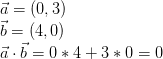

In [54]:
# example dot product calculation
Image("../../raw_data/images/dot_product_calculation.png", width=200)

The CountVectorizer output of the two documents show the word count, where the vectors do not overlap for any words. Thus the dot product is zero.

In [55]:
# dot product equation
Image("../../raw_data/images/dot_product.png", width=500)

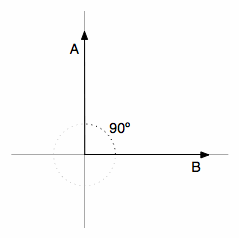

In [56]:
# the geometric interpretation of the vectors a and b
Image("../../raw_data/images/orthogonal_vectors.gif", width=400)

### The Norm

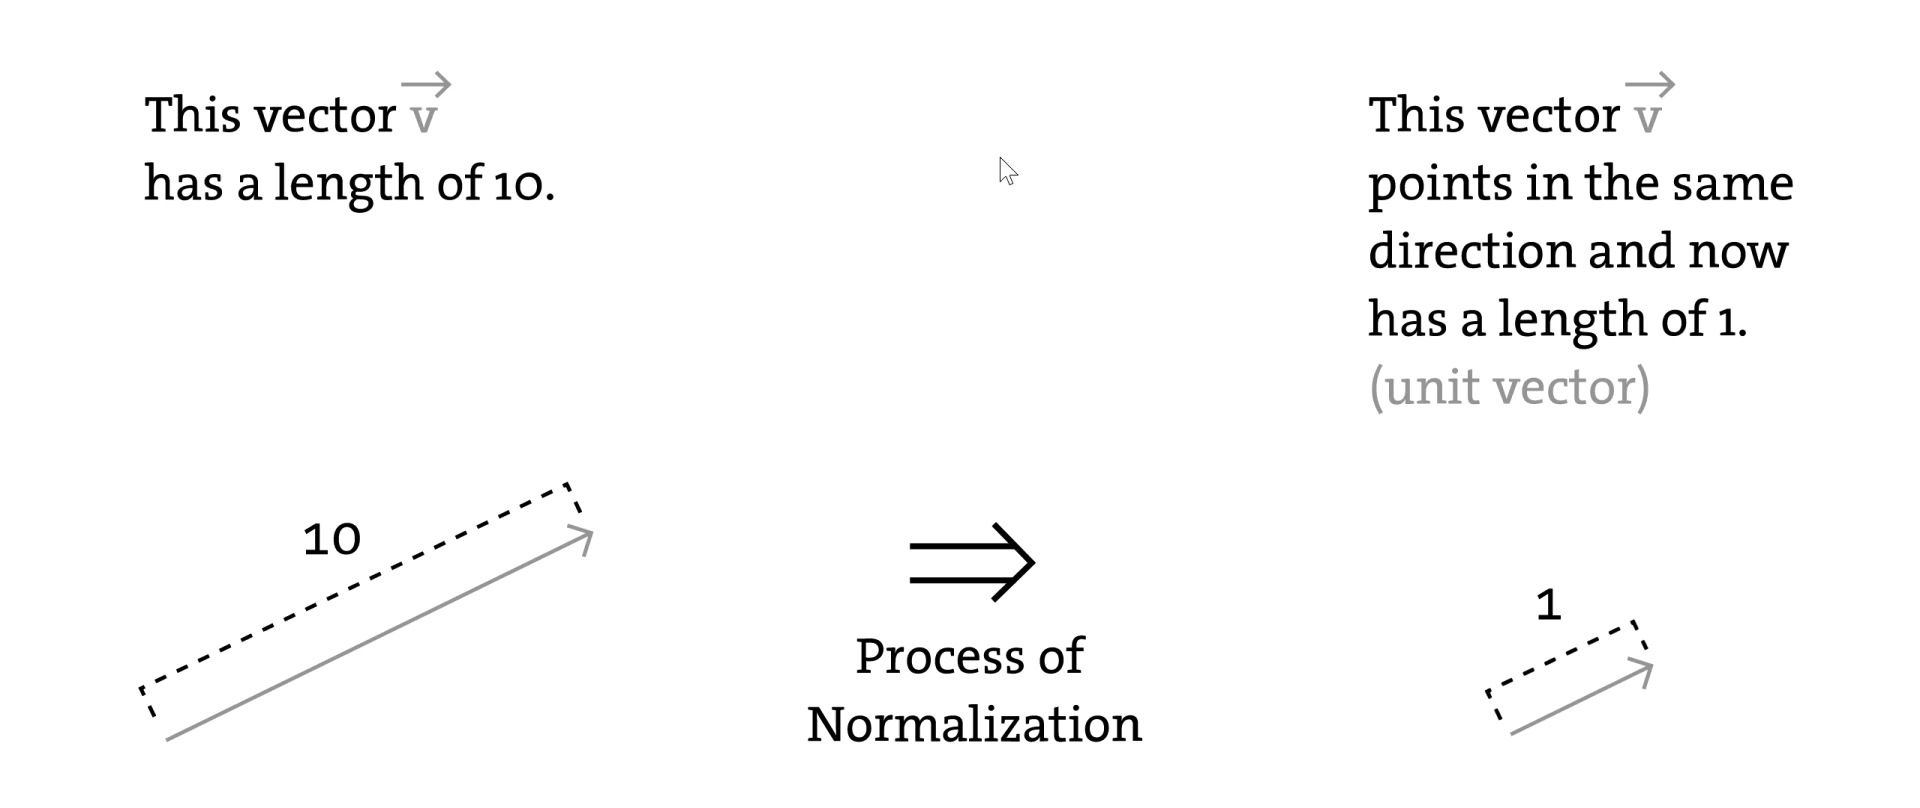

In [57]:
# the geometric equation of the dot product
Image("../../raw_data/images/normalization.png", width=800)

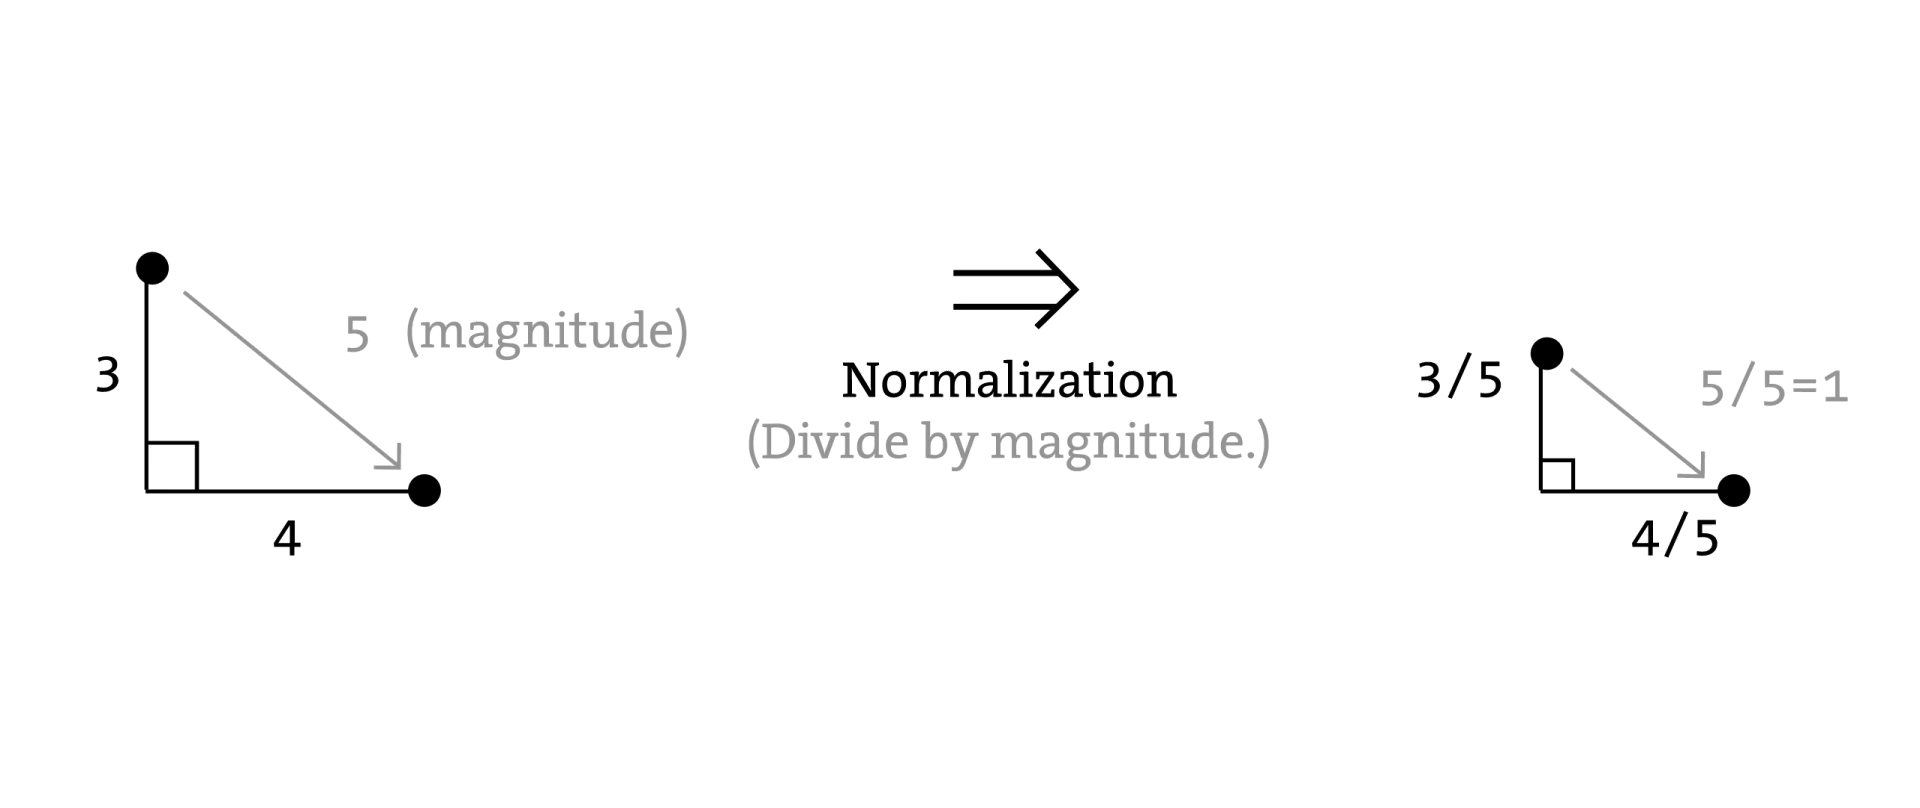

In [58]:
# the geometric equation of the dot product
Image("../../raw_data/images/normalization_example.png", width=800)

In [59]:
norm_url = 'https://rorasa.wordpress.com/2012/05/13/l0-norm-l1-norm-l2-norm-l-infinity-norm/'
iframe = '<iframe src={} width=1100 height=300></iframe>'.format(norm_url)
HTML(iframe)

##### cosine similarity
The cosine similarity between two vectors (or two documents on the Vector Space) is a measure that calculates the cosine of the angle between them. This metric is a measurement of orientation and not magnitude, it can be seen as a comparison between documents on a normalized space because we’re not only taking into the consideration the magnitude of each word count (tf-idf) of each document, but also the angle between the documents. What we have to do to build the cosine similarity equation is to solve the equation of the dot product for cosine:


That is the cosine similarity formula. Cosine Similarity will generate a metric that says how related are two documents by looking at the angle instead of the magnitude.

In [60]:
# the geometric equation of the dot product
Image("../../raw_data/images/geometric_dot_product.png", width=200)

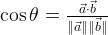

In [61]:
# cosine similarity equation
Image("../../raw_data/images/cosine_similarity.png", width=200)

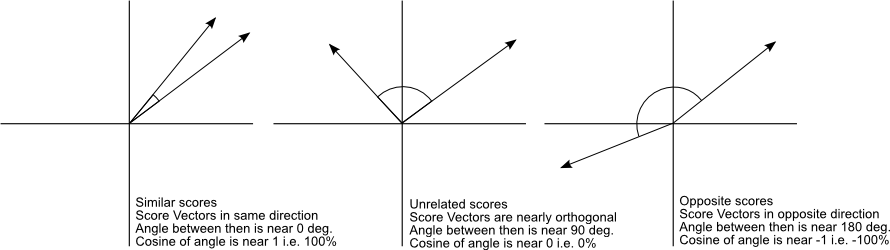

In [62]:
# cosine similarity angles
# 1 = perfect match
# 0 = dissimilar documents
Image("../../raw_data/images/cosine_similarity_angles.png", width=1200)

In [63]:
cosine_url = 'http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/'
iframe = '<iframe src={} width=950 height=300></iframe>'.format(cosine_url)
HTML(iframe)

# Similarity with sklearn

### tfidf -> lsi -> cosine similarity (sklearn)

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create tfidf matrix
df = pd.DataFrame(cleaned_text[0:5], columns=['text'])
vect = TfidfVectorizer(max_features=15)
transform_vect = vect.fit_transform(df['text'])
pd.DataFrame(transform_vect.toarray(), columns=vect.get_feature_names())

,airport,and,be,can,fee,have,in,of,one,or,passenger,per,that,the,to
0,0.000000,0.000000,0.000000,0.000000,0.196275,0.472901,0.472901,0.279303,0.000000,0.000000,0.000000,0.000000,0.000000,0.660451,0.000000
1,0.000000,0.178194,0.000000,0.632585,0.211825,0.000000,0.255183,0.301430,0.255183,0.255183,0.255183,0.000000,0.211825,0.356387,0.000000
2,0.884835,0.332334,0.000000,0.000000,0.000000,0.000000,0.000000,0.281086,0.000000,0.000000,0.000000,0.000000,0.000000,0.166167,0.000000
3,0.000000,0.122761,0.527399,0.000000,0.145930,0.175800,0.000000,0.207660,0.175800,0.000000,0.175800,0.435798,0.145930,0.245521,0.527399
4,0.000000,0.254550,0.364529,0.000000,0.000000,0.000000,0.000000,0.215297,0.000000,0.364529,0.000000,0.000000,0.302592,0.000000,0.729059


In [65]:
from sklearn.decomposition import TruncatedSVD

# reduce dimensions of tfidf matrix
svd = TruncatedSVD()
svd_tranform = svd.fit_transform(transform_vect)
print(svd_tranform)

[[ 0.60753942 -0.58768296]
 [ 0.69525588 -0.39795424]
 [ 0.39721195 -0.32685627]
 [ 0.82078621  0.39770975]
 [ 0.7138704   0.61232001]]


##### Build a recommendation engine with cosine similarity

In [66]:
from sklearn.neighbors import NearestNeighbors

# identify cosine distance
neighbors = NearestNeighbors(metric='cosine')
neighbors.fit(svd_tranform)
neighbors.kneighbors([svd_tranform[0]])

(array([[0.        , 0.00321842, 0.03082081, 0.65635023, 0.90709861]]),
 array([[0, 2, 1, 3, 4]], dtype=int64))

In [67]:
# cosine similarity matrix
ind = ['doc{}'.format(i) for i in range(1,6)]
graph = neighbors.kneighbors_graph(n_neighbors=2, mode='distance').toarray()
pd.DataFrame(graph, columns=ind, index=ind)

,doc1,doc2,doc3,doc4,doc5
doc1,0.000000,0.030821,0.003218,0.000000,0.000000
doc2,0.030821,0.000000,0.014191,0.000000,0.000000
doc3,0.003218,0.014191,0.000000,0.000000,0.000000
doc4,0.000000,0.435589,0.000000,0.000000,0.033038
doc5,0.000000,0.664670,0.000000,0.033038,0.000000


The similarity in vector space models is determined by using associative coefficients based on the inner product of the document vector and query vector, where word overlap indicates similarity. The inner product is usually normalized. The most popular similarity measure is the cosine coefficient, which measures the angle between a document vector and the query vector.

Think about it this way. In the numerator of cosine similarity, only terms that exist in both documents contribute to the dot product. If both of the term have high tfidf values, then they add a lot to the numerator. If a term does not exist in either documents, then it adds nothing to the numerator. On the other hand, the deonominator normalizes the documents, so that a document with many terms is punished with a larger denominator. 


SOURCE: http://cogsys.imm.dtu.dk/thor/projects/multimedia/textmining/node5.html

### Problems with Cosine Distance
Cosine similarity does not require exact matches. Unfortunately, the bag-of-words approach implies a word order independence that can overstate document similarity. The sentences ***“I am not a crook”** versus **“Am I not a crook?”** would receive a perfect cosine similarity score of 1, despite their intentions being entirely different

### Additional Material - Weighted Cosine Similarity

Weighted cosine similarity measure: iteratively computes the cosine distance between two documents, but at each iteration the vocabulary is defined by n-grams of different lengths. 

The weighted similarity measure gives a single similarity score, but is built from the cosine similarity between two documents taken at several levels of coarseness. Put simply, we tokenize the two documents with unigrams, compute the cosine similarity between them, and then retokenize the documents with bigrams and again compute the similarity. We repeat this process until we reach our user-defined maximum n-gram length. The resulting set of scores is then combined as a weighted average, where heavier weights are given to the similarity scores between word frequency vectors from the higher n-gram lengths. 

Like the basic cosine similarity score, the weighted version varies from 0 to 1. the weighted cosine approach can capture pairs of documents where one copies but edits another. Since this is often the case in copied legislation, judicial decisions or regulations, we expect the weighted cosine similarity score to potentially better represent the similarity between technical documents


SOURCE:
- [Comparing and Evaluating Cosine Similarity Scores,
Weighted Cosine Similarity Scores, & Substring
Matching](http://hansen.web.unc.edu/files/2014/12/AHJS_Weighted_Cosine.pdf)

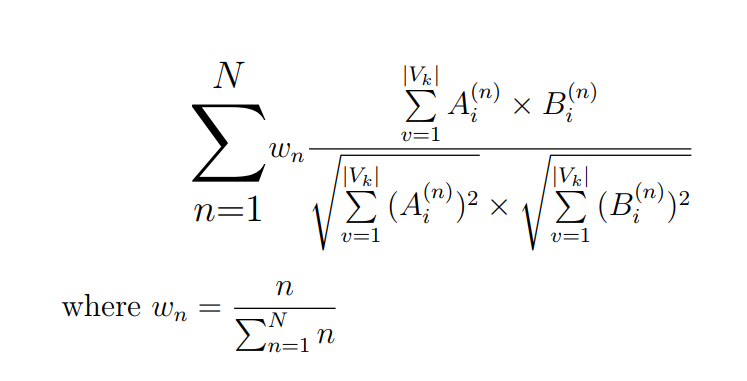

In [68]:
# weighted cosine similarity
Image("../../raw_data/images/weighted_cosine_similarity.png", width=400)

##  Similarity with gensim (generate similarity)

##### bow -> tfidf -> lsi in gensim 

In [69]:
# convert sentences into list of tokens to format data for gensim
texts = [text.split() for text in cleaned_text]
print(texts[0])

['the', 'plaintiff', 'in', 'the', 'consolidate', 'florida', 'action', 'have', 'file', 'a', 'motion', 'seek', 'a', 'award', 'of', 'fee', 'in', 'the', 'amount', 'of', 'which', 'the', 'defendant', 'have', 'oppose']


In [70]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)

# filter the dictionary to remove infrequent (no_below) and too frequent (no_above) terminology
dictionary.filter_extremes(no_below=.01, no_above=0.05)

print(dictionary)

Dictionary(1013 unique tokens: ['as', 'taxis', 'confirmation_and_viii', 'addition', 'market']...)


In [71]:
# create bag of words (e.g. countvectorizer)
bow_corpus = [dictionary.doc2bow(sent) for sent in texts]

# create tfidf model (e.g. tfidf.fit )
tfidf = models.TfidfModel(bow_corpus)

# convert bow to tfidf (e.g. tfidf.transform)
tfidf_corpus = tfidf[bow_corpus] 

# view the first transformed sentence
print(tfidf_corpus[0])

[(0, 0.2899203410904586), (1, 0.2430321088160598), (2, 0.27045996642168657), (3, 0.2430321088160598), (4, 0.31734819869608527), (5, 0.364236430970484), (6, 0.31734819869608527), (7, 0.31734819869608527), (8, 0.364236430970484), (9, 0.2899203410904586), (10, 0.27045996642168657)]


In [72]:
# Optional uncomment below to read in the same tfidf data from prior lesson
# dictionary = corpora.Dictionary.load(GENSIM_DICTIONARY_PATH)
# tfidf_corpus = corpora.MmCorpus(GENSIM_CORPUS_PATH)

In [79]:
# create an lsi model (e.g. truncatedsvd.fit)
# corpus = data to fit model
# id2word = corpus stores words with numeric ids, this dict maps ids back to the original terms
lsi = models.LsiModel(corpus=tfidf_corpus, id2word=dictionary, num_topics=2)
print(lsi)

LsiModel(num_terms=1013, num_topics=2, decay=1.0, chunksize=20000)


In [74]:
# convert the tfidf corpus to lsi (e.g. truncatedsvd.transform)
lsi_corpus = lsi[tfidf_corpus]
print(lsi_corpus[0])

[(0, -0.020045546059204902), (1, 0.0027429294849153404)]


### Index Documents for similarity recommendations (gensim)

**Compute the cosine similarity of a dynamic query against a static corpus of documents**

- gensim.similarities.**MatrixSimilarity**: for an efficient, memory-mapped index -- dense NumPy implementation


- gensim.similarities.**SparseMatrixSimilarity**: for an efficient, memory-mapped index -- sparse SciPy implementation


- gensim.similarities.**Similarity**: for an efficient out-of-core sharded index (auto-selects MatrixSimilarity or SparseMatrixSimilarity for each shard internally, based on the shard density); this is the most flexible class and should be your first choice.

In [81]:
from gensim.similarities import MatrixSimilarity, SparseMatrixSimilarity, Similarity

# transform corpus to LSI space and index it
# output_prefix - local file to write index (required to enable later additions to the index)
# corpus - data to fit model
# num_features - often the num_terms in the corpus

index = Similarity(
      output_prefix='lsi.mm'
    , corpus=lsi_corpus
    , num_features=lsi.num_terms
    , shardsize=32768
)

print(index)

Similarity index with 218 documents in 0 shards (stored under lsi.mm)


In [82]:
# add documents to a existing Similarity index (e.g. useful for big data and streaming)

print(index)  # before
index.add_documents(lsi_corpus)
print(index)  # after

Similarity index with 218 documents in 0 shards (stored under lsi.mm)
Similarity index with 436 documents in 0 shards (stored under lsi.mm)


In [83]:
index.save(SIMILARITY_INDEX)

In [84]:
index = Similarity.load(SIMILARITY_INDEX)
print(index)

Similarity index with 436 documents in 1 shards (stored under lsi.mm)


### Similarity Query

In [85]:
# tokenize a query string
query = "Airline fee for landing_fee".lower().split()
print(query)

# convert to bag of words
vec_bow = dictionary.doc2bow(query)

# convert bow to tfidf
tfidf[bow_corpus] 

# convert tfidf to LSI space to prepare for similarity query
vec_lsi = lsi[vec_bow]

print(vec_lsi)

['airline', 'fee', 'for', 'landing_fee']
[(0, -0.006602271220622281), (1, -0.010419880552712264)]


In [86]:
# set the number of matches to return (sorted by most relevant)
index.num_best = 3

# perform a similarity query against the index (similarity index of training docs)
sims = index[vec_lsi]

print('num docs: {}'.format(len(sims)))
sims

num docs: 3


[(105, 0.9979766011238098), (323, 0.9979766011238098), (172, 0.99713134765625)]

In [91]:
# NOTE: we add the same documents to the index twice, so the returned sims number may be out of range 
# for the original texts (if so just divide the index by two before slicing texts)
print(texts[105])

['for', 'example', 'the', 'company', 'transfarencysm', 'campaign_emphasize', 'southwest_approach', 'to', 'treat_customers', 'fairly_honestly', 'and', 'respectfully_with_its_low', 'fare_and_no_unexpected', 'bag', 'fee', 'change', 'fee', 'or', 'hide', 'fee']


##### NOTE: These queries only consider semantic similarity, and ignore important behavior driven features

### BM25 (Best Match)

- [bm25 gensim source code](https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/summarization/bm25.py)

In [92]:
from gensim.summarization.bm25 import get_bm25_weights

In [93]:
scores = get_bm25_weights(bow_corpus)
print(scores[0])

[46.21961553091006, 0, 0, 0, 0, 0, 0, 0, 3.4825517570777715, 0, 0, 0, 0, 0, 0, 0, 12.429355163551495, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.859148143911612, 0, 0, 0, 12.088702079167806, 15.911906920629265, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.4825517570777715, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.859148143911612, 0, 3.4825517570777715, 0, 0, 0, 3.4825517570777715, 0, 0, 0, 0, 3.4825517570777715, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.455430052011786, 0, 0, 0, 3.4825517570777715, 0, 0, 0, 0, 0, 0, 0, 3.859148143911612, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.4825517570777715, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.4825517570777715, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.4825517570777715, 0, 0, 0, 0, 0, 0]


In [94]:
bm25_df = pd.DataFrame(scores).T
bm25_df['text'] = cleaned_text
bm25_df.head()

,0,1,2,3,4,5,6,7,8,9,...,209,210,211,212,213,214,215,216,217,text
0,46.219616,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.992141,0.000000,...,0.0,0.000000,3.101323,0.0,0.0,0.0,0.0,0.000000,0.000000,the plaintiff in the consolidate florida action have file a motion seek a award of fee in the amount of which the defendant have oppose
1,0.000000,56.02272,0.000000,0.000000,0.000000,3.365134,0.0,0.0,0.000000,0.000000,...,0.0,3.345471,0.000000,0.0,0.0,0.0,0.0,12.475847,30.926462,in congress_may_consider comprehensive_tax reform_legislation which can result_in_a_low corporate_tax rate_and_the_elimination of certain_tax deduction_and_preference a good a separate legislation...
2,0.000000,0.00000,40.540887,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,landing_fee and other rental_per_available_seat_mile increase_percent primarily_a_a_result of the company expansion of facility at several airport include baltimore washington international airpor...
3,0.000000,0.00000,0.000000,68.472129,0.000000,0.000000,0.0,0.0,0.000000,3.803113,...,0.0,0.000000,3.436694,0.0,0.0,0.0,0.0,0.000000,0.000000,vided that with respect to revocation the certificate ginning february a per enplanement holder have 1 be advise of the allege violation and security fee be impose on passenger maximum of fail to ...
4,0.000000,0.00000,0.000000,0.000000,60.890419,0.000000,0.0,0.0,2.992141,0.000000,...,0.0,3.510243,0.000000,0.0,0.0,0.0,0.0,0.000000,2.676831,as discuss below under ancillary services and fees during southwest intend to implement a service charge for reuse of fund associate with wanna get away ticket that be not cancel or change prior t...


## Similarity with SpaCy

### Similarity

spaCy is able to compare two objects, and make a prediction of how similar they are. Predicting similarity is useful for building recommendation systems or flagging duplicates. For example, you can suggest a user content that's similar to what they're currently looking at, or label a support ticket as a duplicate if it's very similar to an already existing one.

In [95]:
nlp = spacy.load('en_core_web_lg')

##### Document Similarity

In [97]:
from itertools import combinations

doc1 = nlp(u"Paris is the largest city in France.")
doc2 = nlp(u"Vilnius is the capital of Lithuania.")
doc3 = nlp(u"An emu is a large bird.")
doc4 = nlp(u"seagulls flying by the beach")

doc_combos = list(combinations([doc1, doc2, doc3, doc4], r=2))
doc_combos

[(Paris is the largest city in France., Vilnius is the capital of Lithuania.),
 (Paris is the largest city in France., An emu is a large bird.),
 (Paris is the largest city in France., seagulls flying by the beach),
 (Vilnius is the capital of Lithuania., An emu is a large bird.),
 (Vilnius is the capital of Lithuania., seagulls flying by the beach),
 (An emu is a large bird., seagulls flying by the beach)]

In [98]:
for doc, other_doc in doc_combos:
    print(doc)
    print(other_doc)
    print(doc.similarity(other_doc), '\n')

Paris is the largest city in France.
Vilnius is the capital of Lithuania.
0.7554966079333336 

Paris is the largest city in France.
An emu is a large bird.
0.6921463288355282 

Paris is the largest city in France.
seagulls flying by the beach
0.5691888415127775 

Vilnius is the capital of Lithuania.
An emu is a large bird.
0.566802490555305 

Vilnius is the capital of Lithuania.
seagulls flying by the beach
0.4577826018201699 

An emu is a large bird.
seagulls flying by the beach
0.5974339689995787 



### Similarities in context

Aside from spaCy's built-in word vectors, which were trained on a lot of text with a wide vocabulary, the parsing, tagging and NER models also rely on vector representations of the meanings of words in context. As the processing pipeline is applied spaCy encodes a document's internal meaning representations as an array of floats, also called a tensor. This allows spaCy to make a reasonable guess at a word's meaning, based on its surrounding words. Even if a word hasn't been seen before, spaCy will know something about it. Because spaCy uses a 4-layer convolutional network, the tensors are sensitive to up to four words on either side of a word.

In [101]:
from itertools import product

def create_similarity_matrix(texts, size, labels=None, viz=True):
    """ build a heatmap of similarity scores """

    # create a heatmap of similarities by iterating through each term 
    # and calculating its similarity to every other term
    # similarity is determined by comparing word vectors or "word embeddings"
    matrix = [t1.similarity(t2) for t1, t2 in product(texts, repeat=2)]
    
    # remove bottom half of matrix (i.e. duplicate data)
    matrix = np.array(matrix).reshape(size,size)    
    matrix = np.triu(matrix)

    # transform similarity scores into a dataframe
    if labels is None:
        labels = [term for term in texts]
    df = pd.DataFrame(matrix, columns=labels, index=labels)
    
    # create a heat map of the similarity scores
    if viz:
        sns.set(rc={'figure.figsize':(10,8)})
        sns.heatmap(df)
    
    return df

,fee,expense,cost,airline,flight,flying
fee,1.0,0.541641,0.607472,0.314347,0.237719,0.099642
expense,0.0,1.000000,0.670875,0.313616,0.207671,0.182266
cost,0.0,0.000000,1.000001,0.382422,0.343166,0.272073
airline,0.0,0.000000,0.000000,1.000000,0.708656,0.518665
flight,0.0,0.000000,0.000000,0.000000,1.000000,0.729347
flying,0.0,0.000000,0.000000,0.000000,0.000000,1.000000


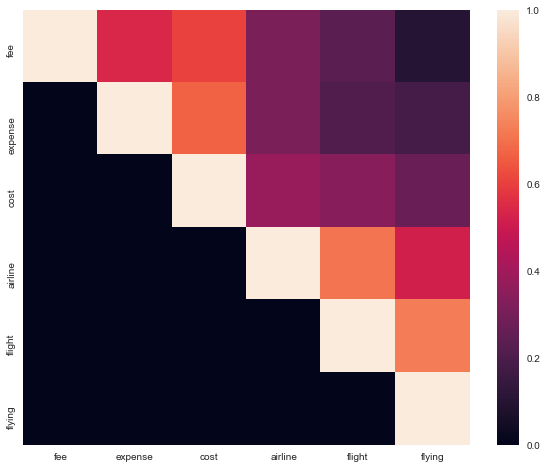

In [102]:
text = ['fee','expense','cost','airline','flight','flying']

create_similarity_matrix(
      texts=nlp(' '.join(text))
    , size=len(text)
)

,in,congress_may_consider,comprehensive_tax,reform_legislation,which,can,result_in_a_low,corporate_tax,rate_and_the_elimination,of,...,the,passenger,pay,fee,use_to_support,the,operation_of_customs,and,border_protection,cbp
in,1.0,0.0,0.0,0.0,0.471656,0.421013,0.0,0.0,0.0,0.542424,...,0.555486,0.151283,0.261833,0.159797,0.0,0.555486,0.0,0.476667,0.0,-0.183426
congress_may_consider,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
comprehensive_tax,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
reform_legislation,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
which,0.0,0.0,0.0,0.0,1.000001,0.621812,0.0,0.0,0.0,0.536856,...,0.623614,0.266969,0.418792,0.323280,0.0,0.623614,0.0,0.594882,0.0,-0.149106
can,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.394680,...,0.504705,0.202782,0.487018,0.331927,0.0,0.504705,0.0,0.547260,0.0,-0.168049
result_in_a_low,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
corporate_tax,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
rate_and_the_elimination,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
of,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.000000,...,0.713939,0.185983,0.331022,0.280109,0.0,0.713939,0.0,0.583599,0.0,-0.179359


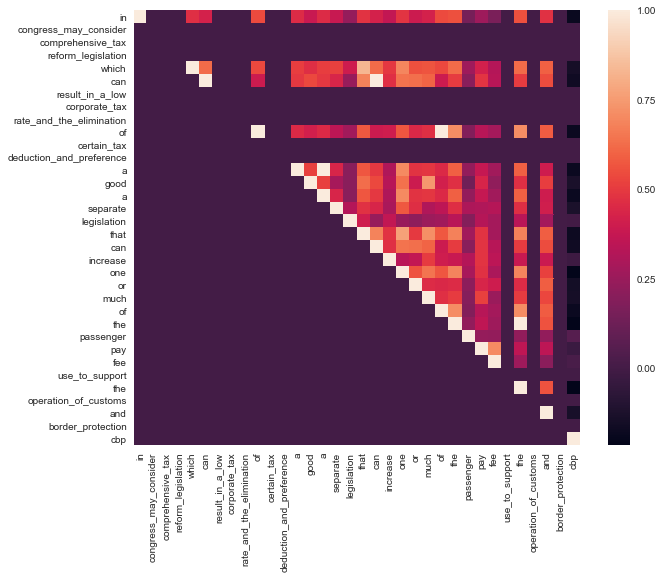

In [103]:
sns.set(rc={'figure.figsize':(12,10)})
create_similarity_matrix(
      nlp(cleaned_text[1])
    , size=len(cleaned_text[1].split())
)

##### Sentence Similarity using the full dataset

In [104]:
%%time

# use set to avoid looking at the similarity of dupliate sentences
docs = [nlp(sentence) for sentence in set(cleaned_text)]

Wall time: 24.3 s


In [105]:
# compare the similarity of all sentences against each other
similarity_scores = []
for doc1 in docs:
    for doc2 in docs:
        # don't compare a sentence against itself
        if doc1.text != doc2.text:
            similarity_scores.append([doc1.text, doc2.text, doc1.similarity(doc2)])

# view the top most similar sentences
# drop sentences with greater than .99 similarity as these are often duplicates
df = pd.DataFrame(similarity_scores, columns=['doc1','doc2','similarity'])
df[df.similarity < .97].sort_values('similarity', ascending=False).head(10)

,doc1,doc2,similarity
33810,when this occur airport cost be allocate_among_a_few_numb of total_flight which can result in increase_land fee and other cost for the company,additionally_when_other_airline reduce_their_capacity airport cost_be_then_allocate among a few numb_of_total flight which have result in increase_land fee and other cost for the company,0.969911
38347,additionally_when_other_airline reduce_their_capacity airport cost_be_then_allocate among a few numb_of_total flight which have result in increase_land fee and other cost for the company,when this occur airport cost be allocate_among_a_few_numb of total_flight which can result in increase_land fee and other cost for the company,0.969911
42164,the company intend_upon_full_integration of airtran_to_have_a_consistent product_offer without 1_or_2 bag fee or change fee,the company have state that it intend_upon_full_integration of airtran_to_have_a_consistent product_offer without 1_or_2 bag fee or change fee,0.969513
14515,the company have state that it intend_upon_full_integration of airtran_to_have_a_consistent product_offer without 1_or_2 bag fee or change fee,the company intend_upon_full_integration of airtran_to_have_a_consistent product_offer without 1_or_2 bag fee or change fee,0.969513
42628,southwest be conjurer_the_only_major airline_that_doe not impose a fee on any of its fare for a customer_change in flight reservation,southwest be conjurer_the_only_major airline_that_doe not impose a fee for a customer_change in flight plan,0.969208
21027,southwest be conjurer_the_only_major airline_that_doe not impose a fee for a customer_change in flight plan,southwest be conjurer_the_only_major airline_that_doe not impose a fee on any of its fare for a customer_change in flight reservation,0.969208
10238,on a dollar_basis approximately_percent of the increase be due to a increase in revenue_relate cost_associate with the percent increase in passenger revenue such a credit_card process fee and appr...,on a per available_seat_mile_basis landing_fee and other rental_expense for decrease_percent compare with a the dollar increase be much than offset by the percent increase in capacity,0.968653
8509,on a per available_seat_mile_basis landing_fee and other rental_expense for decrease_percent compare with a the dollar increase be much than offset by the percent increase in capacity,on a dollar_basis approximately_percent of the increase be due to a increase in revenue_relate cost_associate with the percent increase in passenger revenue such a credit_card process fee and appr...,0.968653
47131,under this new_rule effective_december the per passenger agriculture_inspection fee be and the per commercial_aircraft fee be in in addition to federal_aviation_administration reauthorization legi...,under this rule which be effective_december the per passenger agriculture_inspection fee be and the per commercial_aircraft fee be,0.968300
9330,under this rule which be effective_december the per passenger agriculture_inspection fee be and the per commercial_aircraft fee be,under this new_rule effective_december the per passenger agriculture_inspection fee be and the per commercial_aircraft fee be in in addition to federal_aviation_administration reauthorization legi...,0.968300


### Word Movers Distance

From Word Embeddings To Document Distances Abstract: http://proceedings.mlr.press/v37/kusnerb15.pdf

### Word2Vec Similarity Examples:

SOURCE: https://quomodocumque.wordpress.com/2016/01/15/messing-around-with-word2vec/

### Word2Vec Similarity Training Data

http://download.tensorflow.org/data/questions-words.txt